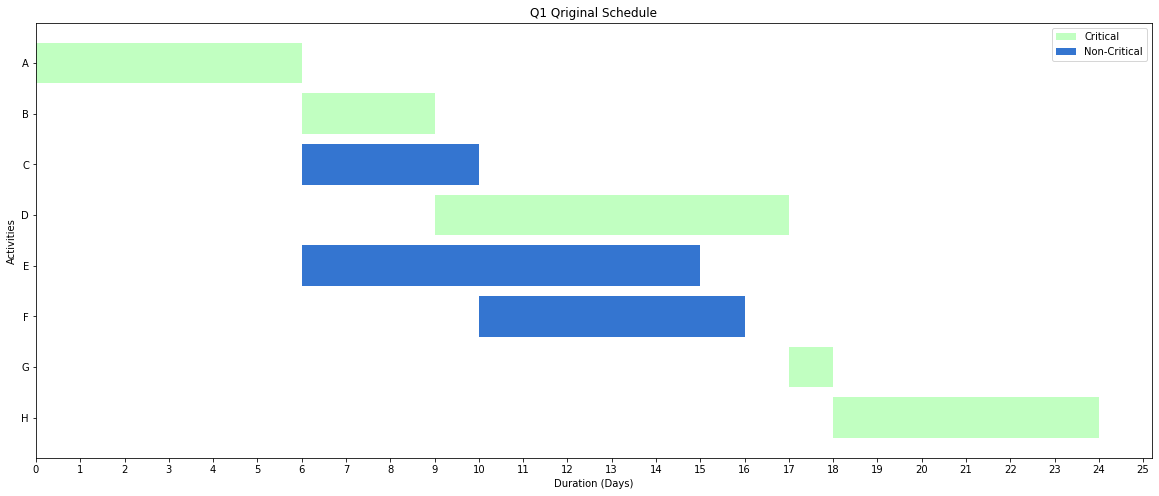

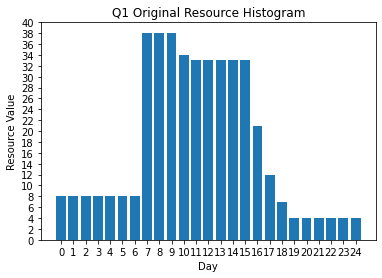

Moving:  C  by:  8
Moving Successor:  F
Moving:  E  by:  3


<Figure size 432x288 with 0 Axes>

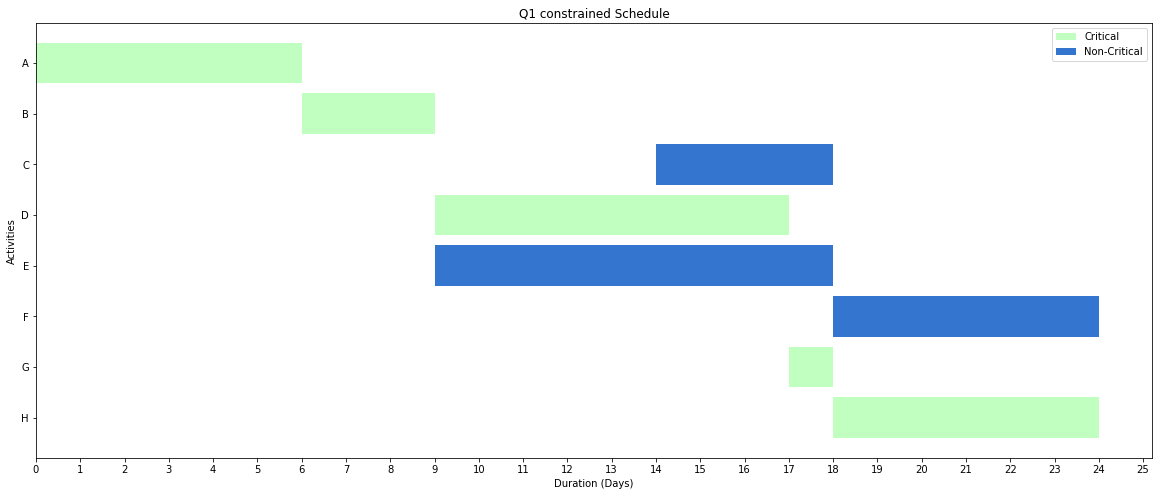

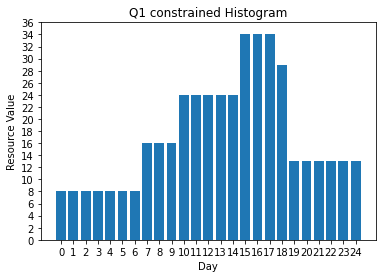

<Figure size 432x288 with 0 Axes>

In [22]:
"""

Assignment:  A1 - Resource constraining

Author: Mehulkumar Jariwala, Akshaykumar Dhorajiya

Due Date: 8 NOV, 2022

Language: PYTHON

To Compile: open the code in the colab, update the csv file at 
CSV_PATH = "/content/Assignment_2_Q1.csv"



Not Addressed: N/A - The program can't take the constraint input from the user.
In constraining the duration may be extended but we could not able to address the same.

Input: CSV file

Output: This program generates the  original schdule , original histogram, Constrained schedule and, Constrained histogram as well it will represent the node that are moving.
 note  address :Instead of taking the constrained limit this code will constrained to the max without affecting the schdule.

Algorithm: The following data structures / algorithms were used:
        1. Class Node to store activity information (ES, EF, LS, LF, TF, LF, predecessors, successors, is_critical)
        2. A recursive travers_forward and traverse_backward implementation is used to ensure that the formulae to calculate the 
           activity parameters is satisfied.
        3. A DFS Graph algorithm is used to find the critical path(s). It visits all critical nodes_dict from start to end and keeps
           track of all possible paths.
        4. Determine the day or days when resources are used to the fullest. Get non-essential nodes_dict close by. 
        5. Shift the non-critical nodes_dict by the corresponding float values, and make sure their succeeding nodes_dict are also shifted in the same manner. 
        6. The successor is not shifted if it is a critical node. 
        7. The project's duration is unaffected because no crucial nodes_dict are changed

Known Bugs: N/A
"""
#importing libraries
from __future__ import annotations
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import os




#creating class name node to store the various value of node
class Node:
    activity: str           # Stores activity name
    duration: int           # Stores activity duration
    es: int                 # Early Start
    ef: int                 # Early Finish
    ls: int                 # Late Start
    lf: int                 # Late Finish
    tf: int                 # Total Float
    ff: int                 # Float
    Previous: list[Node]        # Predecessor nodes_dict
    next: list[Node]        # Successor nodes_dict
    is_critical: str        # Is node critical or not
    resources: int

    # Initializer
    def __init__(self, activity :str, duration: int):
        self.activity = activity
        self.duration = duration
        self.es = None
        self.ef = None
        self.ls = None
        self.lf = None
        self.tf = None
        self.ff = None

        self.Previous = []
        self.next = []

        self.is_critical = "No"

        self.resources = 0
        self.crash_duration = 0
        self.normal_cost = 0
        self.crash_cost = 0

    # Defining the function to print the class node
    def __repr__(self) -> str:
        return "{" \
            f"\"Activity\":\"{self.activity}\", " \
            f"\"Duration\":\"{self.duration}\", " \
            f"\"ES\":\"{self.es}\", " \
            f"\"EF\":\"{self.ef}\", " \
            f"\"LS\":\"{self.ls}\", " \
            f"\"LF\":\"{self.lf}\", " \
            f"\"TF\":\"{self.tf}\", " \
            f"\"FF\":\"{self.ff}\", " \
            f"\"Previous\":\"{list(map(lambda node: node.activity, self.Previous))}\", " \
            f"\"next\":\"{list(map(lambda node: node.activity, self.next))}\", " \
            f"\"Resources\":\"{self.resources}\", " \
            f"\"Critical Path\":\"{self.is_critical}\"" \
            "}\n"
    
    def get_duration(self):
        return self.duration
    
    def set_duration(self, duration):
        self.duration = duration
    
    

    def get_ES(self):
        return self.es
    
    def set_ES(self, ES):
        self.es = ES

    def get_EF(self):
        return self.ef
    
    def set_EF(self, EF):
        self.ef = EF
    
    def is_Critical(self):
        return self.is_critical
    
    def get_successors(self):
        return self.next
    
    def get_activity(self):
        return self.activity
    
    def get_TF(self):
        return self.tf
    
    def get_resources(self):
        return self.resources
       

# Read the csv file and returns a pandas df object
def read_csv(path):
    return pd.read_csv(path)

# Creating the nodes_dict
def generate_nodes_dict(csv) -> list[str, Node]:
    # implying the extinct node on the both end
    nodes_dict = {
        "Start": Node(activity="Start", duration=0),
        "End": Node(activity="End", duration=0)
    }

    columns = csv.columns

    # Iterate through the dataframe
    for ind, row in csv.iterrows():
        if row["Activity"] not in nodes_dict:
            # Add new nodes_dict
            activity = row["Activity"]
            node = Node(activity, row["Duration"])

            if ("Resource Requirement/day" in columns):
                node.resources = row["Resource Requirement/day"]
            

            nodes_dict[activity] = node

    #Getting the Previousios and next nodes_dict list
    for ind, row in csv.iterrows():
        # Dependency list
        current = row["Activity"].strip()
        dependents = row["Depends on"].strip().split(",")
        for dependent in dependents:
            dependent = dependent.strip()
            # All predecessors and successors
            if dependent.isalpha():
                nodes_dict[current].Previous.append(nodes_dict[dependent])
                nodes_dict[dependent].next.append(nodes_dict[current])

    # joining the start and end node.
    for node in filter(lambda node: node.activity not in ["Start", "End"], nodes_dict.values()):
        if not node.next:
            node.next.append(nodes_dict["End"])
            nodes_dict["End"].Previous.append(node)

        if not node.Previous:
            node.Previous.append(nodes_dict["Start"])
            nodes_dict["Start"].next.append(node)

    return nodes_dict

# Calculate the travers_forward traversing to get the Es and Ef of the nodes_dict
def travers_forward(end: Node):
    node = end
    max_es = 0

    for predecessor in node.Previous:
      # if predecessor's EF is not defined , Recurse with predecessor node 
        travers_forward(end=predecessor)
        max_es = max(max_es, predecessor.ef)
    # Early start is the maximum value of predecessors EF values
    node.es = max_es
    node.ef = node.es + node.duration

# Calculate the traverse_backward traversing to get the ls and lf of the nodes_dict
def traverse_backward(end: Node):
    node = end
    min_lf = float("inf")
    min_ff = float("inf")

    for successor in node.next:
      #IF successor's LS is not defined, recurse with successsor node
        if (successor.activity != "End"):
            traverse_backward(end=successor)
        min_lf = min(min_lf, successor.ls)
        min_ff = min(min_lf, successor.es - node.ef)

    # Late finish is the minimum value of successors LS values
    node.lf = min_lf
    node.ls = node.lf - node.duration

    # if node is critical set the value is yes
    node.tf = node.ls - node.es

    if (node.tf == 0):
        node.is_critical = "Yes"

    node.ff = min_ff

# determines the number of critical nodes_dict in the programme and returns them.
def count_critical_nodes(nodes_dict):
    """Counts critical nodes
    Args:
        nodes : dictionary of nodes of graph

    Returns:
        int: number of critical nodes
    """
    num_critical = 0
    for node in nodes_dict.values():
        if (node.es - node.ls == 0):
            node.is_critical = "Yes"
            node.tf = 0
            num_critical = num_critical + 1
        else:
            node.tf = node.ls - node.es
    return num_critical

# check whether node is critical or not
def is_critical(node):
    if node["Critical Path"] == "Yes":
        return True
    return False

# Traverses all nodes_dict and forms a (Source, destination) tuple of only the critical nodes_dict
def get_critical_edges(nodes_dict):
    edges = []
    for curr in nodes_dict.values():
        Source_dict = json.loads(repr(curr))

        # Check is current node is critical
        if (not is_critical(Source_dict)):
            continue

        Source = Source_dict["Activity"]
        # Loop through successors
        successors = Source_dict["next"].lstrip("[").rstrip("]").split(",")
        if (successors != ['']):
            for nxt in successors:
                destination = json.loads(repr(nodes_dict[nxt.lstrip(" '").rstrip("'")]))
                # Check whether the destination is critical or not.
                if (is_critical(destination)):
                    edges.append((Source, destination["Activity"]))

    return edges

def get_default_df(value, nodes_dict):
    df = []

    for node in nodes_dict.values():
        node_str = repr(node)
        node_dict = json.loads(node_str)
        df.append(node_dict)
    
    df = pd.DataFrame.from_dict(df)

    # getting the columns value of int from tuple
    
    df["Duration"] = pd.to_numeric(df["Duration"])

    df.drop(columns=["Previous", "next"], axis=1, inplace=True)
    df = df[~df["Activity"].isin(["Start", "End"])]
    df['Color'] = df.apply(color, axis=1)


    
    return df

def get_iterative_df(value, nodes_dict):
    df = []

    for node in nodes_dict.values():
        node_str = repr(node)
        node_dict = json.loads(node_str)
        df.append(node_dict)
    
    df = pd.DataFrame.from_dict(df)
    
    # # getting the columns value of int from tuple
    
    df["Duration"] = pd.to_numeric(df["Duration"])

    df.drop(columns=["Previous", "next"], axis=1, inplace=True)
    df = df[~df["Activity"].isin(["Start", "End"])]
    df['Color'] = df.apply(color, axis=1)

    return df

# Represents a graph data structure using adjacency list
def make_graph(edges, N):
    adjlist = {}
    for (Source, destination) in edges:
        if Source not in adjlist:
            adjlist[Source] = {destination: 1}
        else:
            # Add new destination node
            adjlist[Source][destination] = 1

    # Manually add the "End" node
    adjlist["End"] = {}
    return adjlist

# Function to perform DFS traversal in a directed graph to find the
# complete path between source and destination vertices
def find_all_paths(graph, start, end, path):
    # include the current node in the path
    path = path + [start]
    if start == end:
        return [path]
    if start not in graph:
        return []
    paths = []
    for node in graph[start]:
        # proceed if node is not discovered
        if node not in path:
            newpaths = find_all_paths(graph, node, end, path)
            for newpath in newpaths:
                paths.append(newpath)
    return paths

# create a column with to color the critical path
def color(row):
    c_dict = {'Yes':'#C1FFC1', 'No':'#3475D0'}
    return c_dict[row['Critical Path']]

# Save Gantt-Chart to directory
def save_gantt_chart(df, title, project_start, project_end, xlabel, ylabel):
    fig, ax = plt.subplots(1, figsize=(20,8))

    # Plot Legends
    c_dict = {'Critical':'#C1FFC1', 'Non-Critical':'#3475D0'}
    legend_elements = [Patch(facecolor=c_dict[i], label=i)  for i in c_dict]
    plt.legend(handles=legend_elements)

    # Plot Ticks
    xticks = np.arange(0, project_end+2, 1)
    xticks_labels = np.arange(project_start, project_end+2)

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks_labels[::1])

    # Gantt Chart
    ax.barh(df.Activity, pd.to_numeric(df.Duration), left=pd.to_numeric(df.ES), color=df.Color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.gca().invert_yaxis()

    # Save the figure
    
    plt.show()
    # Clear the current figure
    plt.clf()

# Save Histogram to directory
def save_histogram(df, title, project_start, project_end, xlabel, ylabel):
    resource_dict = {}

    # For each day, maintain total resources
    for i in range(project_start, project_end+1):
        resource_dict[i] = 0

    # Parse through df and add resources for each day
    for ind, row in df.iterrows():
        start_date = int(row["ES"]) + 1
        end_date = int(row["EF"])

        for i in range(start_date, end_date+1):
            resource_dict[i] = resource_dict[i] + int(row["Resources"])

    # Assumption: resources[day = 0] = resources[day = 1]
    resource_dict[0] = resource_dict[1]

    # Plot Histogram
    plt.bar(list(resource_dict.keys()), resource_dict.values())
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(list(resource_dict.keys()))
    plt.yticks(np.arange(project_start, max(resource_dict.values())+4, 2.0))
    
    # Save the figure
    
    plt.show()
    # Clear the current figure
    plt.clf()

    return resource_dict



CSV_PATH = "/content/Assignment_2_Q1 o.csv"
nodes_dict = None

def Constrained(sorted_values, project_end):
        # We can identify the max peaks of our histogram
        day, num_resources = next(iter(sorted_values.items()))

        # As the peak is identified on "day" we can look for non-critical activities
        # around "day"
        activities_around_day = []
        for node in nodes_dict.values():
                # Assumption
                if (day - 4 < node.get_ES() < day + 4):
                        activities_around_day.append(node)

        for node in activities_around_day:
                if (node.is_Critical() == "Yes"):
                        continue
                # This is a non-critical node - can be moved
                # Get current activity's float
                my_float = node.get_TF()
                my_resources = node.get_resources()

                successors = node.get_successors()

                # Only possible to move the current node if any 1 of its successors are non-critical
                can_move_successor = {}
                for successor in successors:
                        if (successor.is_Critical() == "No"):
                                # Can move successor if successor.ef + my_float <= project_end
                                if (successor.get_EF() + my_float <= project_end):
                                        can_move_successor[successor.get_activity()] = successor.get_TF()

                # Assuming we move the current activity by my_float days
                # We must also move the successors by my_float days
                if (can_move_successor):
                        # First move the current node
                        print("Moving: ", node.get_activity(), " by: ", my_float)
                        node.set_ES(node.get_ES() + my_float)
                        node.set_EF(node.get_EF() + my_float)

                        # Now move the successors
                        for successor, float in can_move_successor.items():
                                successor_node = nodes_dict[successor]
                                print("Moving Successor: ", successor_node.get_activity())
                                successor_node.set_ES(successor_node.get_ES() + my_float)
                                successor_node.set_EF(successor_node.get_EF() + my_float)

                if (not can_move_successor):
                        # Successor(s) is critical
                        for successor in successors:
                                # Can move if ES + my_float < successor's ES
                                if (node.get_ES() + my_float <= successor.get_ES()):
                                        print("Moving: ", node.get_activity(), " by: ", my_float)
                                        node.set_ES(node.get_ES() + my_float)
                                        node.set_EF(node.get_EF() + my_float)
                                # As successor is critical, we shouldn't move it

        # We have moved the non-critical nodes_dict around
        # Prepare Database for Gantt-Chart/Histogram
        df = []

        for node in nodes_dict.values():
                node_str = repr(node)
                node_dict = json.loads(node_str)
                df.append(node_dict)

        df = pd.DataFrame.from_dict(df)
        df.drop(columns=["Previous", "next"], axis=1, inplace=True)
        df = df[~df["Activity"].isin(["Start", "End"])]
        df['Color'] = df.apply(color, axis=1)

        project_start = int(json.loads(repr(nodes_dict["Start"]))["ES"])
        project_end = int(json.loads(repr(nodes_dict["End"]))["EF"])

        # Gantt-Chart
        save_gantt_chart(df, "Q1 constrained Schedule", project_start, project_end, "Duration (Days)", "Activities")
        save_histogram(df, "Q1 constrained Histogram", project_start, project_end, "Day", "Resource Value")

       
if __name__ == "__main__":
        # Get graph definition from CSV
        csv = read_csv(CSV_PATH)
        nodes_dict = generate_nodes_dict(csv)

        start = nodes_dict["Start"]
        end = nodes_dict["End"]

        # Populate earliest start and finish by recursing until the end node
        travers_forward(end=end)

        # Update "end" late start and finish values
        end.ls = end.lf = end.es

        # Populate late start and finish by recursing until the start node
        traverse_backward(end=start)

        # Check for critical paths
        N = count_critical_nodes(nodes_dict)

        # Prepare Database for Gantt-Chart/Histogram
        df = []

        for node in nodes_dict.values():
                node_str = repr(node)
                node_dict = json.loads(node_str)
                df.append(node_dict)

        df = pd.DataFrame.from_dict(df)
        df.drop(columns=["Previous", "next"], axis=1, inplace=True)
        df = df[~df["Activity"].isin(["Start", "End"])]
        df['Color'] = df.apply(color, axis=1)

        project_start = int(json.loads(repr(nodes_dict["Start"]))["ES"])
        project_end = int(json.loads(repr(nodes_dict["End"]))["EF"])

        # Gantt-Chart
        save_gantt_chart(df, "Q1 Qriginal Schedule", project_start, project_end, "Duration (Days)", "Activities")

        # Histogram
        resource_dict = save_histogram(df, "Q1 Original Resource Histogram", project_start, project_end, "Day",
                                       "Resource Value")

        sorted_values = {k: v for k, v in sorted(resource_dict.items(), key=lambda item: item[1], reverse=True)}

        Constrained(sorted_values, project_end)
